#Calculating the Observers' Plane Intensity Field

In [12]:
%pylab

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


**Basic Idea**

    1 Load temperature/pressure profiles for the atmosphere
    2 Generate densities vs. altitude, then nu (refractivity vs altitude)
    3 Calculate the alpha, line-of-sight integrated refractivities along a chord as a function of the impact parameter.
    4 Build the opacity aperture: 1's and 0's to represent solid opacities, fractional transmission for hazes.
    5 Build the phase-delay aperture from the alpha field. Pick a wavelength to let us work with a 8192x8192 frame.
    6 Build the "modified aperture function" and take its Fourier transform to get the OPIF.
    7 Rebin the OPIF to something like 1024x1024 (preserve resolution sufficient to match the observign cadence_.

In [13]:
run /Volumes/Kinsman/Felix/Work15/PlutoHaze15/PLHaze_v36.py 

In [14]:
import time
start_time = time.time()

In [15]:
doc_pn = '/Volumes/Kinsman/Felix/Work14/PlutoHaze14/lc01_MTJ_Doc_3.fits'
d = loadtxt('/Volumes/Kinsman/Felix/Work14/PlutoHaze14/table_heat_7_aat.txt', skiprows = 37)

###Get the r, T(r) and P(r) profiles

In [16]:
rSurf = 1186. # From LAY's read-me on the AAT 

In [17]:
r = rSurf + d[:,0] #This first column of d[] is altitude, which we convert to radius here.

In [18]:
T = 1.0 * d[:,1]

In [19]:
P0 = 1.0 * d[:,2] # get temperature and pressure columns (cgs, aka µbar) - with scaling factor of 0.5

In [20]:
lam = 0.5 #microns
PSurf = P0[0] * 1.5 # HERE'S WHERE WE SCALE THE COLUMN ABUNDANCE
gSurf = 61.9 #cm/s^2
P, nu = T2nu(r, T, gSurf, rSurf, PSurf, lam)

### Get Line-of-Sight Integrated Refractivities


In [21]:
lam = 0.5 #Set wavelength in microns for the refractivity calculation

In [22]:
nu = TP2nu(r, T, P, lam)

In [23]:
rMax = r.max() #Set the effective top of the T and P profiles

In [24]:
dr = 1.0 #Calculate nu(r) at this resolution

In [25]:
FOV = 4096.

In [26]:
FOV2 = 0.5*FOV

In [27]:
sMax = 2000.

In [28]:
ds = 1.0 # resolution of step sizes for calculating numerical line-of-sight integral

In [29]:
r_im, a0 = nu2alpha(r, rSurf, nu, rMax, dr, sMax, ds)

In [30]:
aFun = interp1d(r_im, a0, kind='linear', bounds_error=False, fill_value=0.0)

###Build a Phase Screen from the Line-of-Sight Refractivities 

In [31]:
npts = 8192 #About the biggest 2D FFT we can handle in memory is 8192

In [32]:
NP_Ang=0.0 #NP_Ang = 228.32 # Orientation of Pluto's n. pole on the projected sky plane, deg E of N. Pole is visible

#####Here's where we set the oblateness

In [33]:
obl = 0.0

In [34]:
aScr, ap = AlphaScreen0(FOV, npts, aFun, obl, NP_Ang, rSurf)

##### Now calculate the phase screen and calculate the observer's plane intensity field using a Fourier optics approximation

First we'll use a bogus wavelength that depends on the FOV and the number of points

In [35]:
res = FOV/npts #resolution

In [36]:
Z = 31.82 #Distance in AU

In [37]:
Z_km = Z * 149.6e6 #Distance in km

In [38]:
lam_km = res**2 * npts/Z_km

In [39]:
lam_km

4.3022751641082696e-07

In [40]:
k = 2*pi/lam_km #wavenumber of the bogus wavelength

In [41]:
k = 2*pi/lam_km #wavenumber of the bogus wavelength

In [42]:
phases = aScr * k # turn reractivities into phase delays

In [43]:
ap1 = cos(phases) + 1j * sin(phases) #build the complex phase screen

In [44]:
pa = occ_lc(ap1*ap) #The power in the observer's plane intensity field

In [45]:
pa2 = rebin(pa, 512,512)

a.reshape(args[0],factor[0],args[1],factor[1],).sum(1).sum(2)/factor[0]/factor[1]


In [46]:
imshow(pa2)

In [47]:
figure(2)
clf()

In [48]:
plot(pa2[250,:]/median(pa2))

In [49]:
median(pa2)

66957816.57030163

In [50]:
clf()

In [51]:
pa3 = rebin(pa, 1024, 1024)

a.reshape(args[0],factor[0],args[1],factor[1],).sum(1).sum(2)/factor[0]/factor[1]


In [52]:
imshow(pa3)

In [53]:
figure(3)

In [54]:
plot(pa3[500,:])

In [55]:
figure(4)

###Now save pa2 as the OPIF (Observer's Plane Intensity Field)

In [56]:
import astropy.io.fits as pf

In [57]:
pn = '/Volumes/Kinsman/Felix/Work15/PlutoOccs15/' # PATHNAME to the saved fits file, pa2

In [58]:
# pf.writeto(pn + 'OPIF_v01.fits', pa2)

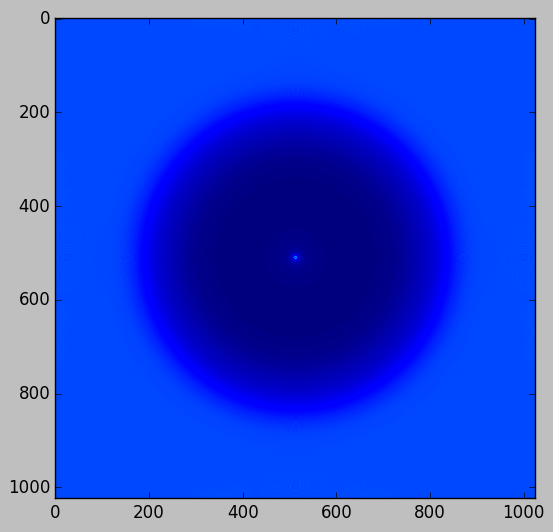

In [59]:
clf()
figure(2)

In [60]:
plot(pa2[175.,:]/median(pa2))

In [67]:
pf.writeto(pn + 'OPIF_v02_1.5Pa.fits', pa3/median(pa3))

In [63]:
figure(4)

In [64]:
t0 = (arange(1024) - 512.) * (4./23.84)

In [65]:
plot(t0, pa3[300,:])

In [66]:
elasped_time = time.time() - start_time
print elasped_time

136.448899984
